### Problem:
We have users and their information about scearching for hotels, they eighter booked for a hotel or just clicked on the hotel. We have 100 different hotel groups and we want to predict the likelihood a user will stay at each of these 100 different hotel groups.

### Import libraries


In [76]:
from imp import reload
import prepare_data
reload(prepare_data)
from prepare_data import *

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,1 hour 49 mins
H2O_cluster_timezone:,Europe/Amsterdam
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.0.1
H2O_cluster_version_age:,27 days
H2O_cluster_name:,sparkling-water-hamed_local-1588324151245
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,494.8 Mb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


In [2]:
spark.catalog.clearCache()

In [77]:
train, test = get_data()
print('size of train',train.cache().count())
print('size of test',test.cache().count())

size of train 44985
size of test 2552


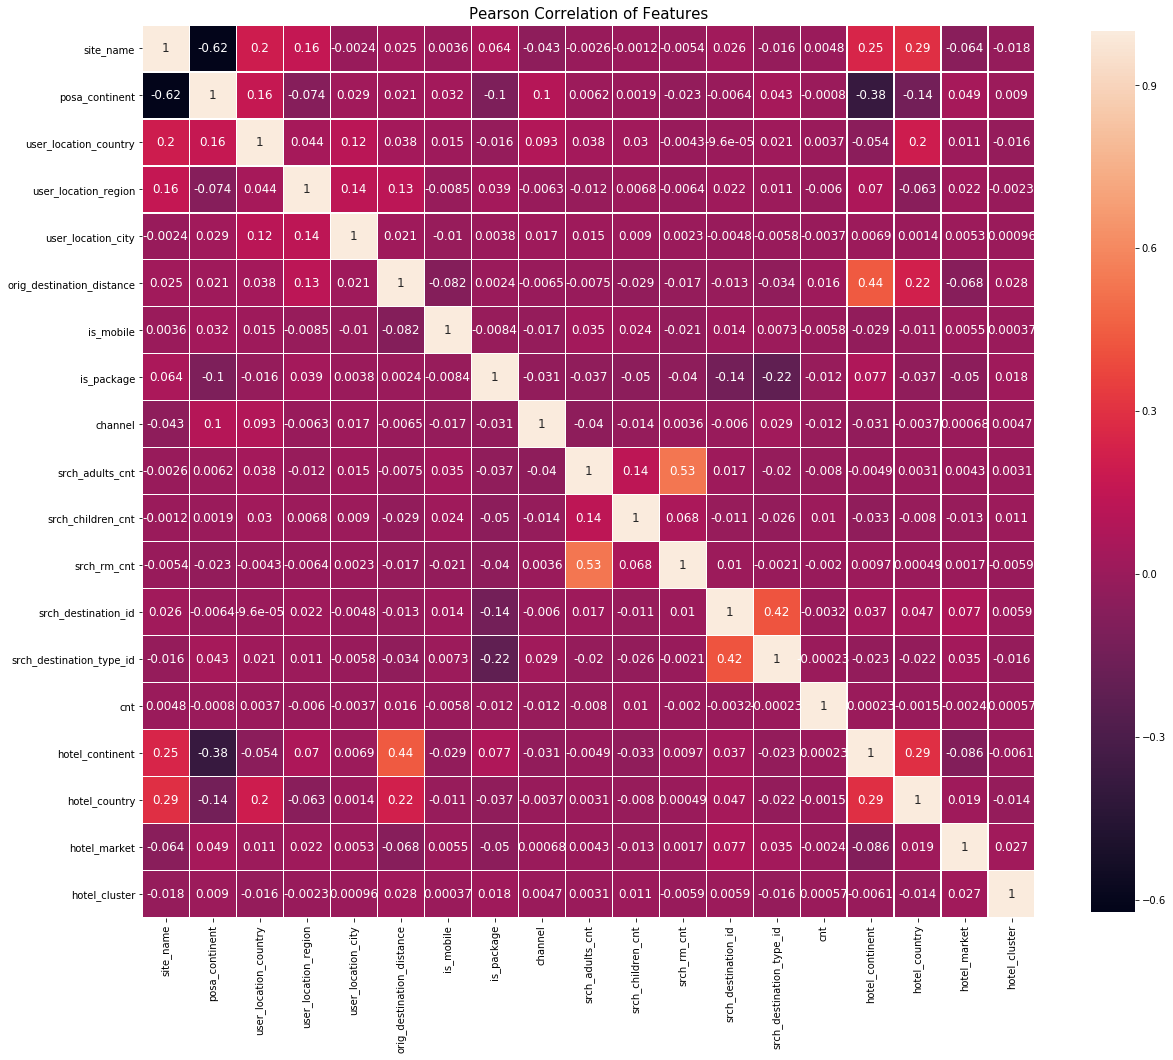

In [78]:
correlation_heatmap(type_to_integer(train,'user_id').drop('user_id','is_booking').toPandas())

In [79]:
corr_target_matrix = (type_to_integer(train,'user_id')
 .drop('user_id','is_booking')
 .toPandas()
 .corr()[['hotel_cluster']]
)
corr_target_matrix

,hotel_cluster
site_name,-0.017604
posa_continent,0.009045
user_location_country,-0.015851
user_location_region,-0.002256
user_location_city,0.000964
orig_destination_distance,0.027611
is_mobile,0.000369
is_package,0.018204
channel,0.004650
srch_adults_cnt,0.003092


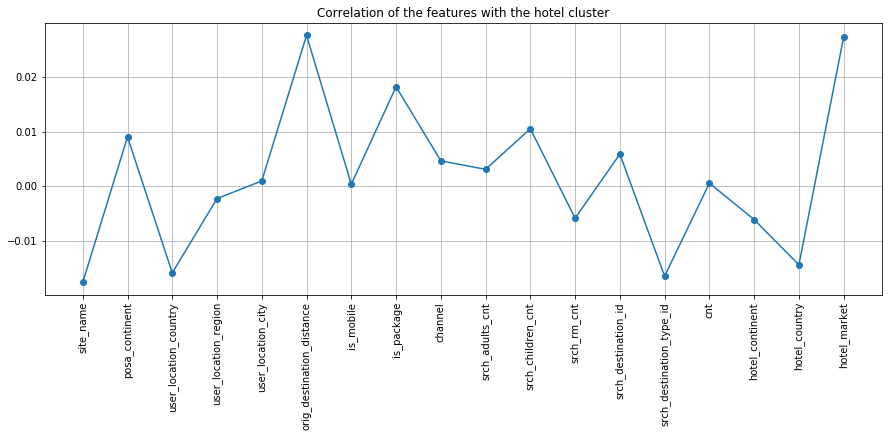

In [80]:
plt.figure(figsize = (15,5))
plt.plot(corr_target_matrix['hotel_cluster'][0:-1], 'o-', label = 'is_booking = 1')
plt.xticks(rotation = 90)
plt.title('Correlation of the features with the hotel cluster')
plt.grid()

The features that seem to have higher correlation with 'hotel_cluster':

In [81]:
imp_features = ['site_name','user_location_country','orig_destination_distance',
               'is_package','srch_children_cnt','srch_destination_type_id','hotel_country','hotel_market']

Let's see which columns do not exist in test database:

In [82]:
col_diff_list = list(set(train.columns) - set(test.columns))
print(col_diff_list)

['is_booking', 'cnt', 'hotel_cluster']


In [84]:
df = combine_train_test(train, test,col_diff_list, test_col_drop = 'id') #improve

In [85]:
print_missing(df)

date_time 0
site_name 0
posa_continent 0
user_location_country 0
user_location_region 0
user_location_city 0
orig_destination_distance 16119
user_id 0
is_mobile 0
is_package 0
channel 0
srch_ci 0
srch_co 0
srch_adults_cnt 0
srch_children_cnt 0
srch_rm_cnt 0
srch_destination_id 0
srch_destination_type_id 0
is_booking 2552
cnt 2552
hotel_continent 0
hotel_country 0
hotel_market 0
hotel_cluster 2552


0

In [86]:
df = (df
      .withColumn('length_stay',
                  F.datediff(end = df['srch_co'],
                             start = df['srch_ci'])
                 )
     )

In [87]:
df = make_positive(df,'length_stay')

In [88]:
df = (df
      .withColumn('booking_window',
                  F.datediff(end = df['srch_ci'],
                             start = df['date_time'])
                 )
     )

In [89]:
df = make_positive(df,'booking_window')

In [90]:
df = parse_date(df)

In [91]:
df = split_TRAIN_TEST_combined(df)

In [92]:
df = df.drop('srch_ci','srch_co','date_time','is_booking')

## Popularity

In [93]:
df = semi_target_encoding(df, col = 'srch_destination_type_id', target = 'hotel_cluster') #'srch_destination_id'
df.cache().count()

47537

## Encode 'hotel_market'

In [107]:
# df = target_encoding(df,'hotel_market', 'hotel_cluster')
# df.cache().count()

## Encode 'user_location_country' and 'hotel_country' and 'user_location_city'

In [16]:
# df = target_encoding(df,'user_location_country', 'hotel_cluster')
# df.cache().count()

42012

In [17]:
# df = target_encoding(df,'hotel_country', 'hotel_cluster')
# df.cache().count()

42012

In [18]:
# df = target_encoding(df,'user_location_city', 'hotel_cluster')
# df.cache().count()

42012

## orig_destination_distance 

In [95]:
df.select('orig_destination_distance').summary().toPandas()

,summary,orig_destination_distance
0,count,31418
1,mean,1677.1240930199235
2,stddev,2152.2840861248433
3,min,0.0098
4,25%,220.4122
5,50%,796.4529
6,75%,2211.0722
7,max,9996.6851


In [96]:
distance_mean = df.agg(F.mean(F.col('orig_destination_distance'))).collect()[0][0]

In [97]:
distance_max =float(df.agg(F.max(F.col('orig_destination_distance'))).collect()[0][0])

In [98]:
df = (df
      .withColumn('orig_destination_distance',
                  F.round(F.col('orig_destination_distance')/distance_max,1))
      .fillna(distance_mean/distance_max, subset=['orig_destination_distance']))

## Preparation for the Models

In [99]:
df = df.select(df.drop('hotel_cluster').columns 
               + df.select('hotel_cluster').columns) 

In [100]:
df = type_to_integer(df,'split')

In [101]:
df_train = df.where(F.col('split') == 'TRAIN').drop('split')
df_test = df.where(F.col('split') == 'TEST').drop('split')

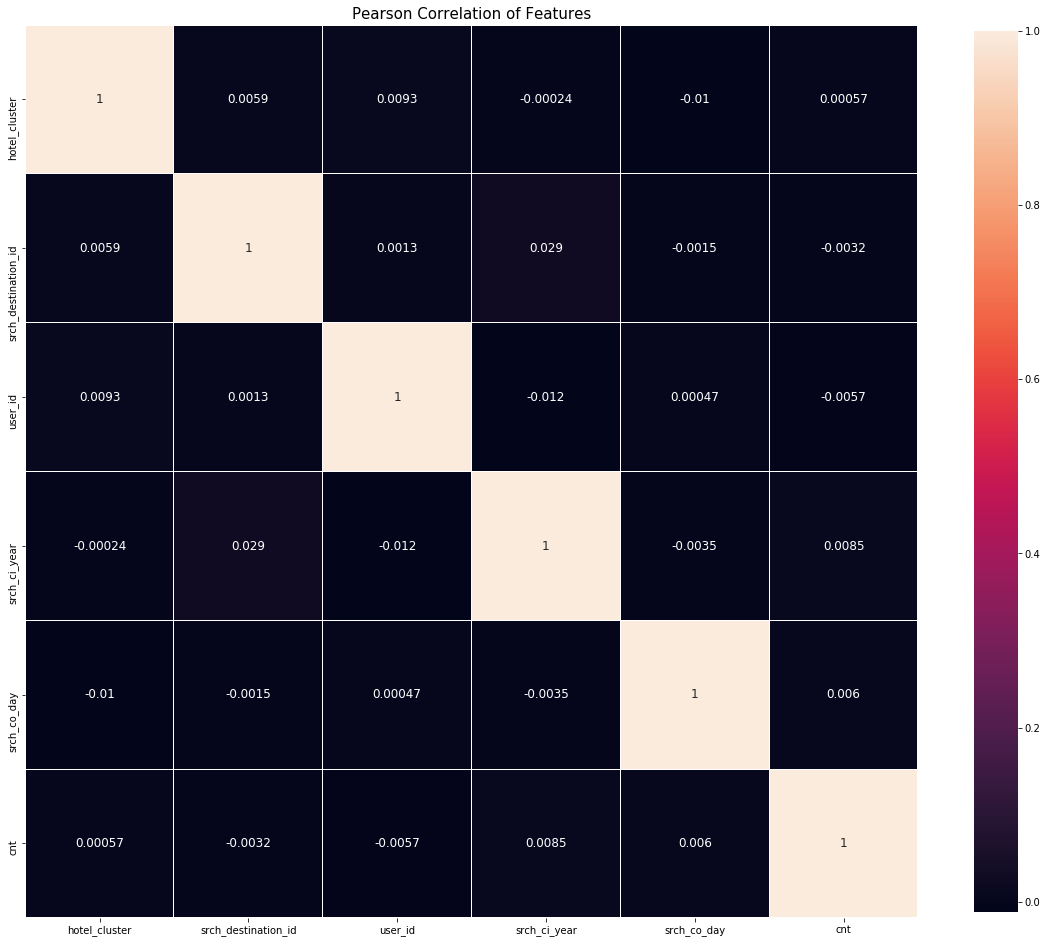

In [102]:
correlation_heatmap(df.select('hotel_cluster','split','srch_destination_id','user_id',
                       'srch_ci_year','srch_co_day','cnt').toPandas())

In [103]:
features_list = df.drop('hotel_cluster','split','srch_destination_id','user_id',
                       'srch_ci_year','srch_co_day','cnt','is_weekend').columns 

## Spark ML

### Cross-validation 

In [104]:
train_cv, test_cv = df_train.randomSplit([0.8,0.2], seed = 42)

In [ ]:
models_list = []
for i in range(2):
    model, pred = build_cv_models(i,'hotel_cluster', features_list,train_cv, test_cv, n_fold = 3)
    models_list.append(model.bestModel)    
    prediction = models_list[i].transform(test_cv)
    print(' Average Mean @5: ',pred_precision_kaggle(prediction, 5))

In [ ]:
prediction = models_list[0].transform(test_cv)
print(' Average Mean @5: ',pred_precision_kaggle(prediction, 5))

In [105]:
models = ['Logestic Regression', 'Random Forest', 'Naive Baise']

for i in range(2):
    prediction = build_models(i,'hotel_cluster', features_list,train_cv, test_cv)
    print('Model '+ models[i],' precision (%): ',pred_precision(prediction))
    print('Model '+ models[i],' Average Mean @5: ',pred_precision_kaggle(prediction, 5))
    print("-"*30)

Model Logestic Regression  precision (%):  6.71
Model Logestic Regression  Average Mean @5:  0.21464845954181241
------------------------------
Model Random Forest  precision (%):  6.77
Model Random Forest  Average Mean @5:  0.2216454124816612
------------------------------


## H2O

In [ ]:
df_train2 = encoding2(df_train, 'hotel_cluster', 'hotel_cluster_onehot')
df_test2 = encoding2(df_test, 'hotel_cluster', 'hotel_cluster_onehot')

In [ ]:
h2o_train = hc.asH2OFrame(df_train2)
h2o_test = hc.asH2OFrame(df_test2)

In [ ]:
predall = []
modelall = []
for i in range(100):
    _,pred,model, _ = build_h2o_models(0,'hotel_cluster_onehot' + str(i), features_list,df_train2,df_test2)
    predall.append(pred)
    modelall.append(h2o_test)

In [ ]:
predh2o = predall[0]
for i in range(1, 99):
    predh2o = predh2o.cbind(predall[i]);

In [ ]:
preds = hc.asSparkFrame(predh2o.cbind(h2o_test['hotel_cluster']))

In [ ]:
preds1.limit(2).toPandas()

In [ ]:
preds = (
    preds.withColumn
    ('prediction', F.array(*preds.columns))
    .select('prediction','hotel_cluster')
        )

In [ ]:
print('Model h2o',' Average Mean @5: ',pred_precision_kaggle(preds1, 5)

In [ ]:
h2o.shutdown(prompt=False)